Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import warnings
import pandas as pd
import plotly_express as px
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor

In [68]:
df=pd.read_csv('https://raw.githubusercontent.com/VeraMendes/Project---Train-a-predictive-model/master/led.csv')
print(df.shape)
df.head()

(2938, 22)


,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# looking into nan's
df.isnull().sum()

Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

In [5]:
# finding the nan's for lifeexpectancy
df[pd.isnull(df['Lifeexpectancy'])]

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
624,CookIslands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1650,MarshallIslands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1715,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1812,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1909,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1958,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2167,SaintKittsandNevis,2013,Developing,NaN,NaN,0,8.54,0.000000,97.0,0,...,96.0,6.14,96.0,0.1,NaN,NaN,3.7,3.6,0.749,13.4
2216,SanMarino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


In [28]:
# finding the nan's for GDP
df[pd.isnull(df['GDP'])]

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
160,Bahamas,2015,Developing,76.1,147.0,0,NaN,0.0,95.0,0,...,95.0,NaN,95.0,0.1,NaN,NaN,2.5,2.5,0.790,12.6
161,Bahamas,2014,Developing,75.4,16.0,0,9.45,0.0,96.0,0,...,96.0,7.74,96.0,0.1,NaN,NaN,2.5,2.5,0.789,12.6
162,Bahamas,2013,Developing,74.8,172.0,0,9.42,0.0,97.0,0,...,97.0,7.50,97.0,0.1,NaN,NaN,2.5,2.5,0.790,12.6
163,Bahamas,2012,Developing,74.9,167.0,0,9.50,0.0,96.0,0,...,99.0,7.43,98.0,0.2,NaN,NaN,2.5,2.5,0.789,12.6
164,Bahamas,2011,Developing,75.0,162.0,0,9.34,0.0,95.0,0,...,97.0,7.63,98.0,0.1,NaN,NaN,2.5,2.5,0.788,12.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2901,Yemen,2004,Developing,62.2,247.0,42,0.06,0.0,43.0,12708,...,72.0,4.90,72.0,0.1,NaN,NaN,13.9,13.9,0.464,8.4
2902,Yemen,2003,Developing,61.9,249.0,43,0.04,0.0,38.0,8536,...,61.0,5.00,61.0,0.1,NaN,NaN,14.0,13.9,0.457,8.2
2903,Yemen,2002,Developing,61.5,25.0,45,0.07,0.0,31.0,890,...,64.0,4.22,65.0,0.1,NaN,NaN,14.0,14.0,0.450,8.0
2904,Yemen,2001,Developing,61.1,251.0,46,0.08,0.0,19.0,485,...,73.0,4.34,73.0,0.1,NaN,NaN,14.0,14.0,0.444,7.9


In [29]:
# finding the nan's for Polio
df[pd.isnull(df['Polio'])]

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
1742,Montenegro,2005,Developing,73.6,133.0,0,NaN,527.307672,NaN,0,...,NaN,8.46,NaN,0.1,3674.617924,614261.0,2.3,2.3,0.746,12.8
1743,Montenegro,2004,Developing,73.5,134.0,0,0.01,57.121901,NaN,0,...,NaN,8.45,NaN,0.1,338.199535,613353.0,2.3,2.4,0.740,12.6
1744,Montenegro,2003,Developing,73.5,134.0,0,0.01,495.078296,NaN,0,...,NaN,8.91,NaN,0.1,2789.173500,612267.0,2.4,2.4,0.000,0.0
1745,Montenegro,2002,Developing,73.4,136.0,0,0.01,36.480240,NaN,0,...,NaN,8.33,NaN,0.1,216.243274,69828.0,2.5,2.5,0.000,0.0
1746,Montenegro,2001,Developing,73.3,136.0,0,0.01,33.669814,NaN,0,...,NaN,8.23,NaN,0.1,199.583957,67389.0,2.5,2.6,0.000,0.0
1747,Montenegro,2000,Developing,73.0,144.0,0,0.01,274.547260,NaN,0,...,NaN,7.32,NaN,0.1,1627.428930,6495.0,2.6,2.7,0.000,0.0
2414,SouthSudan,2010,Developing,55.0,359.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.0,1562.239346,167192.0,NaN,NaN,0.000,0.0
2415,SouthSudan,2009,Developing,54.3,369.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.2,1264.789980,967667.0,NaN,NaN,0.000,0.0
2416,SouthSudan,2008,Developing,53.6,377.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.2,1678.711862,9263136.0,NaN,NaN,0.000,0.0
2417,SouthSudan,2007,Developing,53.1,381.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.2,NaN,88568.0,NaN,NaN,0.000,0.0


In [30]:
# finding the nan's for thinness5-9years
df[pd.isnull(df['thinness5-9years'])]

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
1715,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
2216,SanMarino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2409,SouthSudan,2015,Developing,57.3,332.0,26,NaN,0.000000,31.0,878,...,41.0,NaN,31.0,3.4,758.725782,11882136.0,NaN,NaN,0.421,4.9
2410,SouthSudan,2014,Developing,56.6,343.0,26,NaN,46.074469,NaN,441,...,44.0,2.74,39.0,3.5,1151.861715,1153971.0,NaN,NaN,0.421,4.9
2411,SouthSudan,2013,Developing,56.4,345.0,26,NaN,47.444530,NaN,525,...,5.0,2.62,45.0,3.6,1186.113250,1117749.0,NaN,NaN,0.417,4.9
2412,SouthSudan,2012,Developing,56.0,347.0,26,NaN,38.338232,NaN,1952,...,64.0,2.77,59.0,3.8,958.455810,1818258.0,NaN,NaN,0.419,4.9
2413,SouthSudan,2011,Developing,55.4,355.0,27,NaN,0.000000,NaN,1256,...,66.0,NaN,61.0,3.9,176.971300,1448857.0,NaN,NaN,0.429,4.9
2414,SouthSudan,2010,Developing,55.0,359.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.0,1562.239346,167192.0,NaN,NaN,0.000,0.0
2415,SouthSudan,2009,Developing,54.3,369.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.2,1264.789980,967667.0,NaN,NaN,0.000,0.0
2416,SouthSudan,2008,Developing,53.6,377.0,27,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.2,1678.711862,9263136.0,NaN,NaN,0.000,0.0


In [5]:
# checkig all my column names
df.columns

Index(['Country', 'Year', 'Status', 'Lifeexpectancy', 'AdultMortality',
       'infantdeaths', 'Alcohol', 'percentageexpenditure', 'HepatitisB',
       'Measles', 'BMI', 'under-fivedeaths', 'Polio', 'Totalexpenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness1-19years',
       'thinness5-9years', 'Incomecompositionofresources', 'Schooling'],
      dtype='object')

In [69]:
# changing my column names
df = df.rename(columns = {
    'Country':'country','Year':'year', 'Status':'development','Lifeexpectancy':'lifespan',
    'AdultMortality':'adult_mortality', 'infantdeaths':'infant_deaths',
    'Alcohol':'alcohol_conpsumption', 'percentageexpenditure':'percentage_expenditure',
    'HepatitisB':'hepatitisb','Measles':'measles','BMI':'BMI','under-fivedeaths':'baby_deaths',
    'Polio':'polio', 'Totalexpenditure':'total_expenditure','Diphtheria':'diphtheria','HIV/AIDS':'HIV/AIDS',
    'GDP':'GDP','Population':'population','thinness1-19years':'thinness_teenager',
    'thinness5-9years':'thinness_children','Incomecompositionofresources':'ICR','Schooling':'education'
})

df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_conpsumption,percentage_expenditure,hepatitisb,measles,...,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [70]:
# dropping nan's for lifespan
df = df.dropna(axis=0, subset=['lifespan'])

In [71]:
# checking dimnesions of my df
df.shape

(2928, 22)

In [72]:
# due to leakage problems, I am creating a new column which is going to be my y_target: next_year_lifespan
df['next_year_lifespan']= df['lifespan'].shift(1)
df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_conpsumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,NaN
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,65.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.5


In [73]:
target = 'next_year_lifespan'

In [74]:
df.head(50)

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_conpsumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,NaN
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,65.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,59.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9,58.8
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7,58.6
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4,58.1
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1,57.5


In [44]:
df['year'].value_counts()

2015    183
2013    183
2011    183
2009    183
2007    183
2005    183
2003    183
2001    183
2014    183
2012    183
2010    183
2008    183
2006    183
2004    183
2002    183
2000    183
Name: year, dtype: int64

In [75]:
# 2015 does not have data on y_target for any country
# With pd.shift, I have moved into 2015 wrong values for the countries considered.
year_2015 = df[df.year == 2015]
year_2015.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_conpsumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,NaN
16,Albania,2015,Developing,77.8,74.0,0,4.60,364.975229,99.0,0,...,6.00,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2,54.8
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,...,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,72.6
48,Angola,2015,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,...,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4,71.3
64,AntiguaandBarbuda,2015,Developing,76.4,13.0,0,NaN,0.000000,99.0,0,...,NaN,99.0,0.2,13566.954100,NaN,3.3,3.3,0.784,13.9,45.3


### Looking into Time Series I am:
### using 2013 & 2014 as test
### using 2011 & 2012 as val
### I cannot use 2015 values as I don't have values for the next year lifespan (2016)

In [77]:
# For my analysis I am dropping 2015 rows to avoid errors and leakage.
df = df[df.year != 2015]
df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_conpsumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,65.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,59.2


In [15]:
# looking into nan's
df.isnull().sum()

country                     0
year                        0
development                 0
lifespan                    0
adult_mortality             0
infant_deaths               0
alcohol_conpsumption       16
percentage_expenditure      0
hepatitisb                544
measles                     0
BMI                        30
baby_deaths                 0
polio                      19
total_expenditure          45
diphtheria                 19
HIV/AIDS                    0
GDP                       414
population                603
thinness_teenager          30
thinness_children          30
ICR                       150
education                 150
next_year_lifespan          0
dtype: int64

In [78]:
# splitting my data into a time series manner
train = df[df['year']<2011]
val = df[(df.year == 2011) | (df.year == 2012)]
test = df[(df.year == 2013) | (df.year == 2014)]
train.shape, val.shape, test.shape

((2013, 23), (366, 23), (366, 23))

In [79]:
# using previous year lifespan, as y_pred = y_baseline
y_baseline = pd.Series(train['lifespan'], index=train.index)
print(y_baseline)

5       58.8
6       58.6
7       58.1
8       57.5
9       57.3
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: lifespan, Length: 2013, dtype: float64


In [80]:
# Arrange data into X features matrix and y target vector
# removing previous year lifespan from all my data
target = 'next_year_lifespan'
baseline_values = 'lifespan'
cols_to_drop = ['next_year_lifespan', 'lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [81]:
# using previous year lifespan, as y_pred = y_baseline to try to find a better model fit
mean_baseline = train['next_year_lifespan'].mean()
y_pred = val['lifespan']
baseline_mae = mean_absolute_error(y_val, y_pred)
print('mean baseline:', train['next_year_lifespan'].mean())
print(f'Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): {baseline_mae:.4f}')

mean baseline: 68.68564331843021
Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): 0.8281


### baseline mae is equal to 0.8281 years.

In [82]:
# using RandomForestRegressor
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1)
)

#Fit on train, score on val
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'development'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': Afghanistan            1
Albania                2
Algeria                3
Angola                 4
AntiguaandBarbuda      5
                    ... 
VietNam              180
Yemen                181
Zambia               182
Zimbabwe             183
NaN                   -2
Length: 184, dtype: int64},
                                         {'col': 'd...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                

In [83]:
y_pred= pipeline.predict(X_val)
# mean absolute error for this model
mae = mean_absolute_error(y_val, y_pred)
print(f"My model's absolut error: {mae:,.2f}")

My model's absolut error: 1.46


### new model is not an improvement from the baseline.

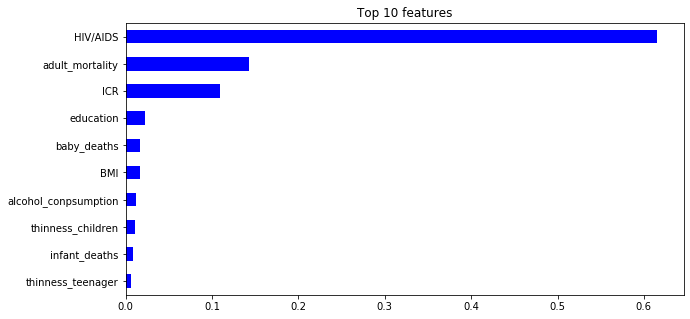

In [84]:
# feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plotting feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

In [85]:
# using pipeline first and then permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [86]:
# using feature permutation on my model
permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [87]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

adult_mortality           2.203286e+00
HIV/AIDS                  1.422532e+00
ICR                       1.409610e+00
alcohol_conpsumption      2.839743e-01
thinness_children         2.830000e-01
education                 1.680464e-01
baby_deaths               1.184169e-01
BMI                       8.824863e-02
country                   7.334809e-02
thinness_teenager         7.087596e-02
total_expenditure         6.687760e-02
infant_deaths             4.232459e-02
percentage_expenditure    3.984699e-02
polio                     3.430055e-02
diphtheria                3.070984e-02
hepatitisb                1.804918e-02
measles                   1.446230e-02
GDP                       1.211421e-02
population                7.130601e-03
development               3.377049e-03
year                     -8.881784e-17
dtype: float64

In [88]:
# looking into feature importance and weight
eli5.show_weights(
    permuter, 
    top=None,
    feature_names = feature_names
)

Weight,Feature
2.2033 ± 0.1069,adult_mortality
1.4225 ± 0.2628,HIV/AIDS
1.4096 ± 0.2129,ICR
0.2840 ± 0.0587,alcohol_conpsumption
0.2830 ± 0.0560,thinness_children
0.1680 ± 0.0520,education
0.1184 ± 0.0478,baby_deaths
0.0882 ± 0.0490,BMI
0.0733 ± 0.0197,country
0.0709 ± 0.0147,thinness_teenager


In [91]:
# fitting a different model:xgboost
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=100, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

C:\Users\Lenovo\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\Lenovo\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:27:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'development'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': Afghanistan            1
Albania                2
Algeria                3
Angola                 4
AntiguaandBarbuda      5
                    ... 
VietNam              180
Yemen                181
Zambia               182
Zimbabwe             183
NaN                   -2
Length: 184, dtype: int64},
                                         {'col': 'd...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
   

In [92]:
# mean absolute error for this model
mae = mean_absolute_error(y_val, y_pred)
y_pred = pipeline.predict(X_val)
print(f"My model's absolut error: {mae:,.2f}")

My model's absolut error: 1.64


### new model is not an improvement from the baseline.

In [61]:
# trying some different parameters on xgboost
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((2013, 21), (366, 21), (2013, 21), (366, 21))

In [93]:
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBRegressor(
    n_estimators=2000,
    max_depth=7,       
    learning_rate=0.1, 
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[15:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:61.3862	validation_1-mae:63.6096
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:55.2679	validation_1-mae:57.3627
[2]	validation_0-mae:49.7611	validation_1-mae:51.7172
[3]	validation_0-mae:44.8007	validation_1-mae:46.6107
[4]	validation_0-mae:40.3368	validation_1-mae:42.0071
[5]	validation_0-mae:36.3182	validation_1-mae:37.8648
[6]	validation_0-mae:32.7016	validation_1-mae:34.1458
[7]	validation_0-mae:29.4477	validation_1-mae:30.7935
[8]	validation_0-mae:26.5177	validation_1-mae:27.7703
[9]	validation_0-mae:23.8791	validation_1-mae:25.0285
[10]	validation_0-mae:21.5038	validation_1-mae:22.5977
[11]	validation_0-mae:19.3667	validation_1-mae:20.3886
[12]	validation_0-mae:17.4434	validation_1-mae:18.3925
[13]	validation_0-mae:

C:\Users\Lenovo\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\Lenovo\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18]	validation_0-mae:9.32996	validation_1-mae:10.0254
[19]	validation_0-mae:8.40774	validation_1-mae:9.07431
[20]	validation_0-mae:7.57761	validation_1-mae:8.23208
[21]	validation_0-mae:6.83211	validation_1-mae:7.48841
[22]	validation_0-mae:6.15911	validation_1-mae:6.79953
[23]	validation_0-mae:5.55477	validation_1-mae:6.20175
[24]	validation_0-mae:5.01069	validation_1-mae:5.6409
[25]	validation_0-mae:4.52443	validation_1-mae:5.13338
[26]	validation_0-mae:4.08198	validation_1-mae:4.70566
[27]	validation_0-mae:3.68447	validation_1-mae:4.30836
[28]	validation_0-mae:3.32733	validation_1-mae:3.94446
[29]	validation_0-mae:3.0076	validation_1-mae:3.61116
[30]	validation_0-mae:2.71928	validation_1-mae:3.31828
[31]	validation_0-mae:2.45948	validation_1-mae:3.06155
[32]	validation_0-mae:2.22614	validation_1-mae:2.8313
[33]	validation_0-mae:2.01877	validation_1-mae:2.62434
[34]	validation_0-mae:1.83522	validation_1-mae:2.44842
[35]	validation_0-mae:1.67136	validation_1-mae:2.29475
[36]	validati

[165]	validation_0-mae:0.200369	validation_1-mae:1.26636
[166]	validation_0-mae:0.198865	validation_1-mae:1.26659
[167]	validation_0-mae:0.196455	validation_1-mae:1.26578
[168]	validation_0-mae:0.193816	validation_1-mae:1.26604
[169]	validation_0-mae:0.190718	validation_1-mae:1.26583
[170]	validation_0-mae:0.188312	validation_1-mae:1.2663
[171]	validation_0-mae:0.186266	validation_1-mae:1.2662
[172]	validation_0-mae:0.18525	validation_1-mae:1.26581
[173]	validation_0-mae:0.183596	validation_1-mae:1.26421
[174]	validation_0-mae:0.181036	validation_1-mae:1.26419
[175]	validation_0-mae:0.18012	validation_1-mae:1.26432
[176]	validation_0-mae:0.177709	validation_1-mae:1.26315
[177]	validation_0-mae:0.176649	validation_1-mae:1.26331
[178]	validation_0-mae:0.175502	validation_1-mae:1.26319
[179]	validation_0-mae:0.174409	validation_1-mae:1.26367
[180]	validation_0-mae:0.172921	validation_1-mae:1.26276
[181]	validation_0-mae:0.17088	validation_1-mae:1.2618
[182]	validation_0-mae:0.170434	valid

[310]	validation_0-mae:0.067116	validation_1-mae:1.24459
[311]	validation_0-mae:0.066327	validation_1-mae:1.24447
[312]	validation_0-mae:0.065799	validation_1-mae:1.24421
[313]	validation_0-mae:0.065257	validation_1-mae:1.24389
[314]	validation_0-mae:0.064737	validation_1-mae:1.24382
[315]	validation_0-mae:0.064299	validation_1-mae:1.24398
[316]	validation_0-mae:0.064082	validation_1-mae:1.24393
[317]	validation_0-mae:0.062898	validation_1-mae:1.24377
[318]	validation_0-mae:0.062584	validation_1-mae:1.24381
[319]	validation_0-mae:0.06203	validation_1-mae:1.24367
[320]	validation_0-mae:0.061512	validation_1-mae:1.24381
[321]	validation_0-mae:0.06125	validation_1-mae:1.2438
[322]	validation_0-mae:0.061045	validation_1-mae:1.2438
[323]	validation_0-mae:0.060538	validation_1-mae:1.24359
[324]	validation_0-mae:0.060327	validation_1-mae:1.2436
[325]	validation_0-mae:0.060089	validation_1-mae:1.24347
[326]	validation_0-mae:0.059618	validation_1-mae:1.24351
[327]	validation_0-mae:0.058929	vali

[455]	validation_0-mae:0.026102	validation_1-mae:1.24153
[456]	validation_0-mae:0.025817	validation_1-mae:1.24146
[457]	validation_0-mae:0.025773	validation_1-mae:1.24148
[458]	validation_0-mae:0.025697	validation_1-mae:1.24146
[459]	validation_0-mae:0.025484	validation_1-mae:1.24148
[460]	validation_0-mae:0.025343	validation_1-mae:1.24145
[461]	validation_0-mae:0.025158	validation_1-mae:1.24144
[462]	validation_0-mae:0.024892	validation_1-mae:1.24145
[463]	validation_0-mae:0.024783	validation_1-mae:1.24153
[464]	validation_0-mae:0.024655	validation_1-mae:1.24153
[465]	validation_0-mae:0.024482	validation_1-mae:1.24143
[466]	validation_0-mae:0.024423	validation_1-mae:1.24142
[467]	validation_0-mae:0.024266	validation_1-mae:1.24139
[468]	validation_0-mae:0.024114	validation_1-mae:1.24138
[469]	validation_0-mae:0.023914	validation_1-mae:1.24124
[470]	validation_0-mae:0.023804	validation_1-mae:1.24124
[471]	validation_0-mae:0.023651	validation_1-mae:1.24124
[472]	validation_0-mae:0.023479

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### new model is not an improvement from the baseline.

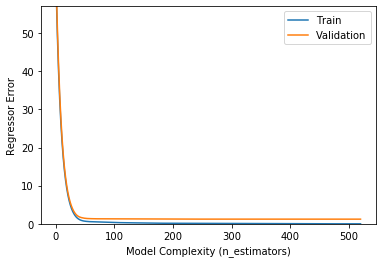

In [63]:
results = model.evals_result()
train_error = results['validation_0']['mae']
val_error = results['validation_1']['mae']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Regressor Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0, 57)) 
plt.legend();